In [1]:
import numpy as np
import pandas as pd
import os
import re

https://www.kaggle.com/code/shinkoshi/2nd-place-solution

https://www.kaggle.com/competitions/mens-march-mania-2022/discussion/317365

https://www.kaggle.com/competitions/ncaam-march-mania-2021/discussion/231665

https://www.kaggle.com/competitions/ncaam-march-mania-2021/discussion/231063

https://www.kaggle.com/competitions/ncaaw-march-mania-2021/discussion/231528

https://www.kaggle.com/competitions/ncaaw-march-mania-2021/discussion/232903

https://www.kaggle.com/competitions/ncaaw-march-mania-2021/discussion/231872

In [2]:
DATA_PATH = '/kaggle/input/march-machine-learning-mania-2023/'

for filename in sorted(os.listdir(DATA_PATH)):
    print(filename)

Cities.csv
Conferences.csv
MConferenceTourneyGames.csv
MGameCities.csv
MMasseyOrdinals_thru_Season2023_Day128.csv
MNCAATourneyCompactResults.csv
MNCAATourneyDetailedResults.csv
MNCAATourneySeedRoundSlots.csv
MNCAATourneySeeds.csv
MNCAATourneySlots.csv
MRegularSeasonCompactResults.csv
MRegularSeasonDetailedResults.csv
MSeasons.csv
MSecondaryTourneyCompactResults.csv
MSecondaryTourneyTeams.csv
MTeamCoaches.csv
MTeamConferences.csv
MTeamSpellings.csv
MTeams.csv
SampleSubmission2023.csv
WGameCities.csv
WNCAATourneyCompactResults.csv
WNCAATourneyDetailedResults.csv
WNCAATourneySeeds.csv
WNCAATourneySlots.csv
WRegularSeasonCompactResults.csv
WRegularSeasonDetailedResults.csv
WSeasons.csv
WTeamConferences.csv
WTeamSpellings.csv
WTeams.csv


# Building Men's Team Model First

In [3]:
df_seeds = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv"),
], ignore_index=True)
    
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [4]:
df_season_results = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonCompactResults.csv")
], ignore_index=True)

df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

df_season_results['ScoreGap'] = df_season_results['WScore'] - df_season_results['LScore']

In [5]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,ScoreGap
0,1985,20,1228,81,1328,64,17
1,1985,25,1106,77,1354,70,7
2,1985,25,1112,63,1223,56,7
3,1985,25,1165,70,1432,54,16
4,1985,25,1192,86,1447,74,12


Feature List (To Add to):
1. Wins
2. Losses
3. Win Gap
4. Loss Gap
5. Win Ratio
6. Avg Score Gap

In [6]:
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

In [7]:
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

In [8]:
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

In [9]:
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})

In [10]:
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

In [11]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

In [12]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')

In [13]:
df_features_season.fillna(0, inplace=True)  

In [14]:
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] - 
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

In [15]:
df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses'], axis=1, inplace=True)

In [16]:
df_features_season

,Season,TeamID,WinRatio,GapAvg
0,1985,1102,0.208333,-5.791667
1,1985,1103,0.391304,-3.043478
2,1985,1104,0.700000,7.800000
3,1985,1106,0.416667,-3.791667
4,1985,1108,0.760000,7.960000
...,...,...,...,...
12657,2023,1473,0.275862,-8.448276
12658,2023,1474,0.500000,0.100000
12659,2023,1475,0.448276,-0.931034
12660,2023,1476,0.433333,-4.266667


In [17]:
df_tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv"),
], ignore_index=True)
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

## 538 Ratings

In [18]:
df_538 = pd.read_csv("../input/ncaa-men-538-team-ratings/538ratingsMen.csv")
df_538.drop('TeamName', axis=1, inplace=True)
df_538.head()

,Season,TeamID,538rating
0,2016,1242,94.46
1,2016,1314,93.94
2,2016,1438,92.46
3,2016,1277,91.84
4,2016,1328,89.96


In [19]:
df = df_tourney_results.copy()
df = df[df['Season'] >= 2016].reset_index(drop=True)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2016,134,1195,96,1192,65
1,2016,134,1455,70,1435,50
2,2016,135,1221,59,1380,55
3,2016,135,1276,67,1409,62
4,2016,136,1114,85,1345,83


In [20]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

In [21]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

In [22]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

In [23]:
df_seeds

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374
...,...,...,...
2485,2023,Z12,1433
2486,2023,Z13,1233
2487,2023,Z14,1213
2488,2023,Z15,1421


In [24]:
df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

In [25]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2016,134,1195,96,1192,65,16,16
1,2016,134,1455,70,1435,50,11,11
2,2016,135,1221,59,1380,55,16,16
3,2016,135,1276,67,1409,62,11,11
4,2016,136,1114,85,1345,83,12,5


In [26]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'GapWins': 'GapWinsW',
    'GapLosses': 'GapLossesW',
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
}).drop(columns='TeamID', axis=1)

In [27]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'GapWins': 'GapWinsL',
    'GapLosses': 'GapLossesL',
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
}).drop(columns='TeamID', axis=1)

In [28]:
df = pd.merge(
    df,
    df_538,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingW'})

In [29]:
df = pd.merge(
    df, 
    df_538, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingL'})

In [30]:
df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,WinRatioW,GapAvgW,WinRatioL,GapAvgL,538ratingW,538ratingL
0,2016,134,1195,96,1192,65,16,16,0.551724,2.724138,0.548387,-1.677419,71.41,66.72
1,2016,134,1455,70,1435,50,11,11,0.741935,13.709677,0.593750,9.406250,86.59,85.59
2,2016,135,1221,59,1380,55,16,16,0.424242,-4.333333,0.612903,1.870968,66.85,67.96
3,2016,135,1276,67,1409,62,11,11,0.636364,6.242424,0.645161,4.322581,79.57,79.93
4,2016,136,1114,85,1345,83,12,5,0.870968,9.935484,0.764706,13.147059,78.90,88.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,2022,146,1242,76,1274,50,1,10,0.823529,10.441176,0.696970,3.787879,91.27,81.13
397,2022,146,1314,69,1389,49,8,15,0.727273,5.787879,0.620690,3.931034,83.99,74.17
398,2022,152,1242,81,1437,65,1,2,0.823529,10.441176,0.787879,9.545455,91.27,90.22
399,2022,152,1314,81,1181,77,8,2,0.727273,5.787879,0.823529,13.029412,83.99,89.28


In [31]:
def add_loosing_matches(df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
     }
    win_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('W')})
    win_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('L')})
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
    }
    lose_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('W')})
    lose_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('L')})
    
    win_df = df.copy()
    lose_df = df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], axis=0, sort=False)

In [32]:
df = add_loosing_matches(df)

In [33]:
df

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,538ratingA,538ratingB
0,2016,134,1195,96,1192,65,16,16,0.551724,2.724138,0.548387,-1.677419,71.41,66.72
1,2016,134,1455,70,1435,50,11,11,0.741935,13.709677,0.593750,9.406250,86.59,85.59
2,2016,135,1221,59,1380,55,16,16,0.424242,-4.333333,0.612903,1.870968,66.85,67.96
3,2016,135,1276,67,1409,62,11,11,0.636364,6.242424,0.645161,4.322581,79.57,79.93
4,2016,136,1114,85,1345,83,12,5,0.870968,9.935484,0.764706,13.147059,78.90,88.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,2022,146,1274,50,1242,76,10,1,0.696970,3.787879,0.823529,10.441176,81.13,91.27
397,2022,146,1389,49,1314,69,15,8,0.620690,3.931034,0.727273,5.787879,74.17,83.99
398,2022,152,1437,65,1242,81,2,1,0.787879,9.545455,0.823529,10.441176,90.22,91.27
399,2022,152,1181,77,1314,81,2,8,0.823529,13.029412,0.727273,5.787879,89.28,83.99


In [34]:
cols_to_diff = [
    'Seed', 'WinRatio', 'GapAvg', 
    '538rating'
]

for col in cols_to_diff:
    df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']

# Update seeds on 12th/13th when they release

In [35]:
df_seeds

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374
...,...,...,...
2485,2023,Z12,1433
2486,2023,Z13,1233
2487,2023,Z14,1213
2488,2023,Z15,1421


## Test Data

In [36]:
df_test = pd.read_csv(DATA_PATH + "SampleSubmission2023.csv")

In [37]:
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

In [38]:
df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB
0,2023_1101_1102,0.5,2023,1101,1102
1,2023_1101_1103,0.5,2023,1101,1103
2,2023_1101_1104,0.5,2023,1101,1104
3,2023_1101_1105,0.5,2023,1101,1105
4,2023_1101_1106,0.5,2023,1101,1106


In [39]:
df_test

,ID,Pred,Season,TeamIdA,TeamIdB
0,2023_1101_1102,0.5,2023,1101,1102
1,2023_1101_1103,0.5,2023,1101,1103
2,2023_1101_1104,0.5,2023,1101,1104
3,2023_1101_1105,0.5,2023,1101,1105
4,2023_1101_1106,0.5,2023,1101,1106
...,...,...,...,...,...
130678,2023_3474_3476,0.5,2023,3474,3476
130679,2023_3474_3477,0.5,2023,3474,3477
130680,2023_3475_3476,0.5,2023,3475,3476
130681,2023_3475_3477,0.5,2023,3475,3477


In [40]:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'}).fillna('W01')

In [41]:
df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIdB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'}).fillna('W01')

In [42]:
df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)

In [43]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'GapWins': 'GapWinsA',
    'GapLosses': 'GapLossesA',
    'WinRatio': 'WinRatioA',
    'GapAvg': 'GapAvgA',
}).drop(columns='TeamID', axis=1)

In [44]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'GapWins': 'GapWinsB',
    'GapLosses': 'GapLossesB',
    'WinRatio': 'WinRatioB',
    'GapAvg': 'GapAvgB',
}).drop(columns='TeamID', axis=1)

In [45]:
df_test = pd.merge(
    df_test,
    df_538,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingA'})

In [46]:
df_test = pd.merge(
    df_test,
    df_538,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingB'})

In [47]:
df_test

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,538ratingA,538ratingB
0,2023_1101_1102,0.5,2023,1101,1102,1,1,0.346154,-3.692308,0.437500,-0.125000,NaN,NaN
1,2023_1101_1103,0.5,2023,1101,1103,1,1,0.346154,-3.692308,0.645161,5.838710,NaN,NaN
2,2023_1101_1104,0.5,2023,1101,1104,1,1,0.346154,-3.692308,0.852941,13.676471,NaN,92.57
3,2023_1101_1105,0.5,2023,1101,1105,1,1,0.346154,-3.692308,0.400000,-3.066667,NaN,NaN
4,2023_1101_1106,0.5,2023,1101,1106,1,1,0.346154,-3.692308,0.233333,-10.033333,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
130678,2023_3474_3476,0.5,2023,3474,3476,1,1,NaN,NaN,NaN,NaN,NaN,NaN
130679,2023_3474_3477,0.5,2023,3474,3477,1,1,NaN,NaN,NaN,NaN,NaN,NaN
130680,2023_3475_3476,0.5,2023,3475,3476,1,1,NaN,NaN,NaN,NaN,NaN,NaN
130681,2023_3475_3477,0.5,2023,3475,3477,1,1,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
for col in cols_to_diff:
    df_test[col + 'Diff'] = df_test[col + 'A'] - df_test[col + 'B']

In [49]:
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

In [50]:
df

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,538ratingA,538ratingB,SeedDiff,WinRatioDiff,GapAvgDiff,538ratingDiff,ScoreDiff,WinA
0,2016,134,1195,96,1192,65,16,16,0.551724,2.724138,0.548387,-1.677419,71.41,66.72,0,0.003337,4.401557,4.69,31,1
1,2016,134,1455,70,1435,50,11,11,0.741935,13.709677,0.593750,9.406250,86.59,85.59,0,0.148185,4.303427,1.00,20,1
2,2016,135,1221,59,1380,55,16,16,0.424242,-4.333333,0.612903,1.870968,66.85,67.96,0,-0.188661,-6.204301,-1.11,4,1
3,2016,135,1276,67,1409,62,11,11,0.636364,6.242424,0.645161,4.322581,79.57,79.93,0,-0.008798,1.919844,-0.36,5,1
4,2016,136,1114,85,1345,83,12,5,0.870968,9.935484,0.764706,13.147059,78.90,88.68,7,0.106262,-3.211575,-9.78,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,2022,146,1274,50,1242,76,10,1,0.696970,3.787879,0.823529,10.441176,81.13,91.27,9,-0.126560,-6.653298,-10.14,-26,0
397,2022,146,1389,49,1314,69,15,8,0.620690,3.931034,0.727273,5.787879,74.17,83.99,7,-0.106583,-1.856844,-9.82,-20,0
398,2022,152,1437,65,1242,81,2,1,0.787879,9.545455,0.823529,10.441176,90.22,91.27,1,-0.035651,-0.895722,-1.05,-16,0
399,2022,152,1181,77,1314,81,2,8,0.823529,13.029412,0.727273,5.787879,89.28,83.99,-6,0.096257,7.241533,5.29,-4,0


In [51]:
df_test

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,538ratingA,538ratingB,SeedDiff,WinRatioDiff,GapAvgDiff,538ratingDiff
0,2023_1101_1102,0.5,2023,1101,1102,1,1,0.346154,-3.692308,0.437500,-0.125000,NaN,NaN,0,-0.091346,-3.567308,NaN
1,2023_1101_1103,0.5,2023,1101,1103,1,1,0.346154,-3.692308,0.645161,5.838710,NaN,NaN,0,-0.299007,-9.531017,NaN
2,2023_1101_1104,0.5,2023,1101,1104,1,1,0.346154,-3.692308,0.852941,13.676471,NaN,92.57,0,-0.506787,-17.368778,NaN
3,2023_1101_1105,0.5,2023,1101,1105,1,1,0.346154,-3.692308,0.400000,-3.066667,NaN,NaN,0,-0.053846,-0.625641,NaN
4,2023_1101_1106,0.5,2023,1101,1106,1,1,0.346154,-3.692308,0.233333,-10.033333,NaN,NaN,0,0.112821,6.341026,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130678,2023_3474_3476,0.5,2023,3474,3476,1,1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
130679,2023_3474_3477,0.5,2023,3474,3477,1,1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
130680,2023_3475_3476,0.5,2023,3475,3476,1,1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
130681,2023_3475_3477,0.5,2023,3475,3477,1,1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN


In [52]:
df

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,538ratingA,538ratingB,SeedDiff,WinRatioDiff,GapAvgDiff,538ratingDiff,ScoreDiff,WinA
0,2016,134,1195,96,1192,65,16,16,0.551724,2.724138,0.548387,-1.677419,71.41,66.72,0,0.003337,4.401557,4.69,31,1
1,2016,134,1455,70,1435,50,11,11,0.741935,13.709677,0.593750,9.406250,86.59,85.59,0,0.148185,4.303427,1.00,20,1
2,2016,135,1221,59,1380,55,16,16,0.424242,-4.333333,0.612903,1.870968,66.85,67.96,0,-0.188661,-6.204301,-1.11,4,1
3,2016,135,1276,67,1409,62,11,11,0.636364,6.242424,0.645161,4.322581,79.57,79.93,0,-0.008798,1.919844,-0.36,5,1
4,2016,136,1114,85,1345,83,12,5,0.870968,9.935484,0.764706,13.147059,78.90,88.68,7,0.106262,-3.211575,-9.78,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,2022,146,1274,50,1242,76,10,1,0.696970,3.787879,0.823529,10.441176,81.13,91.27,9,-0.126560,-6.653298,-10.14,-26,0
397,2022,146,1389,49,1314,69,15,8,0.620690,3.931034,0.727273,5.787879,74.17,83.99,7,-0.106583,-1.856844,-9.82,-20,0
398,2022,152,1437,65,1242,81,2,1,0.787879,9.545455,0.823529,10.441176,90.22,91.27,1,-0.035651,-0.895722,-1.05,-16,0
399,2022,152,1181,77,1314,81,2,8,0.823529,13.029412,0.727273,5.787879,89.28,83.99,-6,0.096257,7.241533,5.29,-4,0


In [53]:
# -

In [54]:
# X = np.zeros((len(df), len(np.unique(df[['TeamIdA', 'TeamIdB']].values))))
# y = np.zeros(len(df))
# team_map = {team: i for i, team in enumerate(np.unique(df[['TeamIdA', 'TeamIdB']].values))}
# idxtoone = []
# for i, row in df.iterrows():
#     X[i, team_map[row['TeamIdA']]] = 1
#     X[i, team_map[row['TeamIdB']]] = -1
#     if row["ScoreA"] > row["ScoreB"]:
#         idxtoone.append(i)

# for i in range(len(y)):
#     if i in idxtoone:
#         y[i] = 1
        
# from sklearn.linear_model import LogisticRegression

# model = LogisticRegression(penalty='none', solver='lbfgs', max_iter=1000)
# model.fit(X, y)
# strengths = model.coef_[0]

In [55]:
# for team, strength in sorted(team_map.items(), key=lambda x: strengths[x[1]], reverse=True):
#     print(f'{team}: {strengths[team_map[team]]}')

In [56]:
# btr_df = pd.DataFrame(columns={"Test", "Potat"})
# btr_df

In [57]:
# btr_df.append({"Potat":2, "Test":"something"}, ignore_index=True)

## Model

In [58]:
features = [
    "SeedA", "SeedB", 'WinRatioA', 'GapAvgA', 'WinRatioB', 'GapAvgB', 'SeedDiff', 'WinRatioDiff', 'GapAvgDiff', 
    '538ratingDiff'
]

In [59]:
def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test

# Drops all women ids

In [60]:
df_test.dropna(inplace=True)

In [61]:
def kfold(df, df_test_=None, plot=False, verbose=0, mode="reg"):
    seasons = df['Season'].unique()
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[1:]:
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.copy()
        
        df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)
        
        if mode == "reg":
#             model = LinearRegression()
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            model = LogisticRegression(C=1)

        model.fit(df_train[features], df_train[target])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
        else:
            pred = model.predict_proba(df_val[features])[:, 1]
        
        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[features])
                
#                 print( pred_test.max() - pred_test.min())
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = model.predict_proba(df_test[features])[:, 1]
                
            pred_tests.append(pred_test)
            
        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.title('Prediction vs Score Diff')
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred, bins=20)
            plt.title('Predictions probability repartition')
            plt.show()
        
        pred = (pred - pred.min()) / (pred.max() - pred.min())
        pred = np.clip(pred, 0, 1)

        score = ((df_val['WinA'].values - pred) ** 2).mean()
        cvs.append(score)

        if verbose:
            print(f'\t -> Scored {score:.3f}')
        
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    
    return pred_tests

In [62]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

pd.set_option('display.max_columns', None)

In [63]:
pred_tests = kfold(df, df_test, plot=False, verbose=1, mode="cls")


Validating on season 2017
	 -> Scored 0.183

Validating on season 2018
	 -> Scored 0.207

Validating on season 2019
	 -> Scored 0.168

Validating on season 2021
	 -> Scored 0.220

Validating on season 2022
	 -> Scored 0.223

 Local CV is 0.200


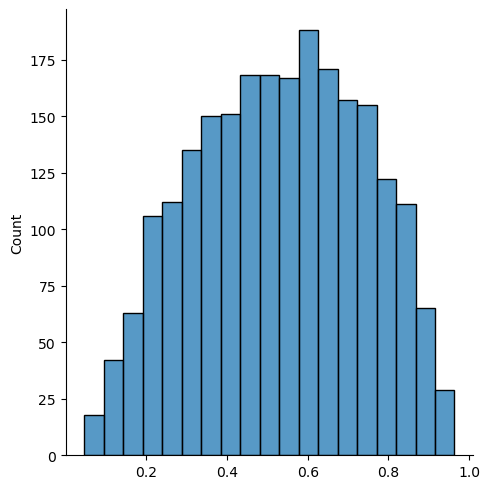

In [64]:
pred_test = np.mean(pred_tests, 0)
df_test['pred'] = pred_test

_ = sns.displot(pred_test)

In [65]:
final_sub = df_test[['ID', 'pred']].copy()
final_sub.to_csv('mmlm2023_men_submission_v2.csv', index=False)

In [66]:
final_sub.head()

,ID,pred
1089,2023_1104_1112,0.581444
1090,2023_1104_1113,0.840350
1093,2023_1104_1116,0.760738
1096,2023_1104_1120,0.784381
1099,2023_1104_1124,0.662747


In [67]:
final_sub

,ID,pred
1089,2023_1104_1112,0.581444
1090,2023_1104_1113,0.840350
1093,2023_1104_1116,0.760738
1096,2023_1104_1120,0.784381
1099,2023_1104_1124,0.662747
...,...,...
64936,2023_1436_1452,0.318648
64946,2023_1436_1462,0.207031
65011,2023_1438_1452,0.622280
65021,2023_1438_1462,0.479488
